In [31]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from yahoo_finance import Share
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import numpy
import matplotlib.pyplot as plt

In [3]:
# Parameters. Choose the stock, and the timeframe of the analysis. Also choose the delta_time of the prediction 
# (look_back variable). Here we chose Google stock price. 

companies = 'GOOG'
initial_date = '2010-01-01'
final_date = '2017-01-01'
look_back = 1



In [4]:
# This function retrieves the closing price of the stock. 

def get_close_quote(stock, time0, time1):
    
    stock1 = Share('%s'%(stock))
    Data = stock1.get_historical('%s'%(time0),'%s'%(time1))

    Data1 = []
    
    for i in range(0,len(Data)):
        Data1.append(Data[i]["Adj_Close"])
    
    return numpy.array(Data1, dtype = float)

In [22]:
# This function normalizes the data (using min max sklearn package). We can achieve better predictions using normalized 
# data. After making the prediciton, we "undo" the normalization using the de_normalization function.


def normalization(data):
    scaler = MinMaxScaler(feature_range = (0,1))
    data_norm = scaler.fit_transform(data)
    
    return data_norm

def de_normalization(data, new_data):
    scaler = MinMaxScaler(feature_range = (0,1))
    scaler.fit_transform(data)
    unormalized = scaler.inverse_transform(new_data)
    
    return unormalized

In [6]:
# Time Series train test split is different from the usual split. We cannot select randomly because the sequence of
# information presented by the time series is important. in this case we will use the first 2/3 of the data set 
# as training set, and the other 1/3 data set as testing set. Latter we will use other methods for comparison. 


def split_train_test(data):
    

    # split into train and test sets
    train_size = int(len(data) * 0.67)
    train, test = data[0:train_size,], data[train_size:len(data),]
    return train, test


In [8]:
# This function creates a dataset with two series, the first one is our database (series of prices), and the second one 
# is the same database that will be predicted. This database is our price list moved one day ahead (look_back variable)


def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
        a = dataset[i:(i+lookback), ]
        dataX.append(a)
        dataY.append(dataset[i + lookback, ])
    return numpy.array(dataX), numpy.array(dataY)


In [23]:
# Here we have the code to retrieve and work the dataset, using the functions defined above. 

dataset = get_close_quote(companies, initial_date, final_date)

dataset_norm = normalization(dataset)

train_dataset, test_dataset = split_train_test(dataset_norm)

train_X, train_y = create_dataset(train_dataset, look_back)

test_X, test_y = create_dataset(test_dataset,look_back)


/Users/ViniciusPantoja/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ViniciusPantoja/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [25]:
# We are going to reshape the X set because the LSTM cells of the tensorflow receives as input the 
# [samples, timesteps, features]
train_X = numpy.reshape(train_X, (train_X.shape[0], 1 , train_X.shape[1]))
test_X = numpy.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))


In [26]:
# Now let's go to the model. First we stablish our model as a sequential one (time series). Than we add four Long Short
# Term Memories, one Dense Layer (it is used change the dimension of the vector), The compile with a loss function and
# an optimizer and finally, the fit function, with 15 epochs. 

model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_y, nb_epoch=15, batch_size=1, verbose=2)


Epoch 1/15
20s - loss: 0.0294
Epoch 2/15
24s - loss: 0.0012
Epoch 3/15
24s - loss: 2.7861e-04
Epoch 4/15
25s - loss: 2.5372e-04
Epoch 5/15
18s - loss: 2.3868e-04
Epoch 6/15
20s - loss: 2.2587e-04
Epoch 7/15
18s - loss: 2.2538e-04
Epoch 8/15
19s - loss: 2.2574e-04
Epoch 9/15
16s - loss: 2.2592e-04
Epoch 10/15
16s - loss: 2.2373e-04
Epoch 11/15
16s - loss: 2.2383e-04
Epoch 12/15
17s - loss: 2.2662e-04
Epoch 13/15
18s - loss: 2.2308e-04
Epoch 14/15
17s - loss: 2.2632e-04
Epoch 15/15
17s - loss: 2.1748e-04


In [27]:
# Now lets make the predictions of the normalized data.
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

In [28]:
# Revert the predictions from normalized to regular values

trainPredict = de_normalization(dataset, trainPredict)
train_y = de_normalization(dataset,train_y)
testPredict = de_normalization(dataset, testPredict)
test_y = de_normalization(dataset,test_y)

/Users/ViniciusPantoja/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ViniciusPantoja/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ViniciusPantoja/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X

In [29]:
# Now lets compute the mean squared error.
trainScore = math.sqrt(mean_squared_error(train_y, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.52 RMSE
Test Score: 9.57 RMSE


/Users/ViniciusPantoja/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ViniciusPantoja/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ViniciusPantoja/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X

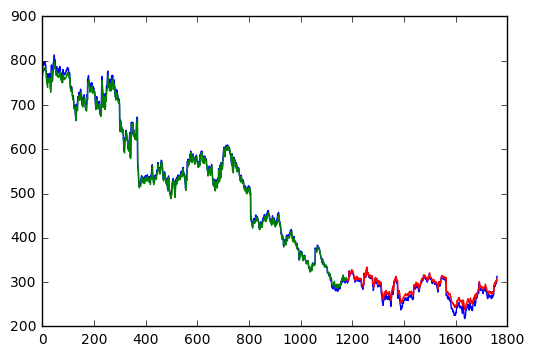

In [32]:


# Now let's plot the results. In blue we have the data, in green the training period, and in red our prediction
trainPredictPlot = numpy.empty_like(dataset_norm)
trainPredictPlot[:, ] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, ] = trainPredict[:,0]
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset_norm)
testPredictPlot[:,] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, ] = testPredict[:,0]
# plot baseline and predictions
plt.plot(de_normalization(dataset,dataset_norm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

